In [1]:
#!conda install -yc conda-forge pyslim
conda activate trans_slim

SyntaxError: invalid syntax (2554142841.py, line 2)

In [2]:
import tskit
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
#import matplotlib.colorbar as mcolorbar

Here are the codes:

In [83]:
ts = tskit.load("/Users/px54/Documents/TB_software/covid_test/test_ourmethod.trees")
n_gens = ts.metadata["SLiM"]["tick"]
sample_size = range(ts.tables.individuals.num_rows)

sampled_tree = ts.simplify(samples = [2 * i for i in sample_size])

leaf_time = n_gens - sampled_tree.tables.nodes.time[sample_size].astype(int)

leaf_id = sampled_tree.tables.nodes.individual[sample_size]
leaf_label = []
for l_id in sample_size:
	leaf_label.append(sampled_tree.tables.individuals[l_id].metadata["subpopulation"])

real_name = {}
for i in sample_size:
	real_name[i] = str(leaf_time[i]) + "." + str(leaf_label[i])

roots_all = sampled_tree.first().roots
for root in roots_all:
	with open("/Users/px54/Documents/TB_software/plot_test/" + str(root) + ".nwk", "w") as nwk:
		nwk.write(sampled_tree.first().as_newick(root = root, node_labels = real_name))
	print(sampled_tree.first().as_newick(root = root, node_labels = real_name))

113.3532;
((149.1965:68,(146.2691:54,(213.4809:103,246.2054:136):18):11):76,((175.7233:112,(98.7594:19,130.3962:51):16):29,((112.2138:41,204.9262:133):33,(94.9070:52,(81.9223:32,(((298.9072:36,315.8770:53):13,(262.5443:12,298.7018:48):1):61,(275.2627:42,(304.9320:56,(257.9356:4,(272.6680:14,323.7373:65):5):5):15):45):139):7):4):4):29);
((((((138.5633:60,195.1218:117):16,((150.993:74,((163.6451:78,301.1933:216):8,(141.9086:63,(206.6492:127,(118.1682:3,311.5884:196):36):1):1):1):13,((217.5310:131,(128.9309:41,163.1010:76):1):12,(102.5072:24,(191.2114:100,202.6859:111):13):4):11):1):15,(((171.5161:8,302.3053:139):102,((163.3030:3,263.6522:103):83,(101.667:21,(134.4493:22,144.7970:32):32):3):16,(111.2092:37,171.9652:97):13):12,(((205.6847:120,(290.7266:98,(262.1935:25,286.8878:49):45):107):22,(153.9865:82,(106.2737:34,271.6016:199):1):8):6,(((220.1274:150,(134.1313:35,138.2070:39):29):4,(120.6114:52,(128.1872:53,203.50:128):7):2):7,(((309.8072:121,(303.5630:54,(290.1622:15,339.1335:64):26)

Save the vcf file (it seems that there are some problems of the REF and ALT allele)

Color the tree based on (transmissibility or mutations)

In [8]:
## Read in the effect size csv file
eff_size = pd.read_csv("/Users/px54/Documents/TB_software/covid_test/causal_gene_info.csv")
num_trait = eff_size.shape[1] - 3
search_intvls = []
for i in range(eff_size.shape[0]):
    search_intvls.append(eff_size["start"][i])
    search_intvls.append(eff_size["end"][i])
print(eff_size)
print(num_trait)

   gene_name  start    end  eff_size_t1  eff_size_t2  eff_size_t3
0    region1    100    400         0.15          0.0          0.0
1  region_dr   9124   9126         0.00          0.7          0.0
2    region3  15000  15500         0.00          0.0          0.6
3    region2  20000  20500         0.05          0.0          0.0
4    region3  28000  28300         0.10          0.0          0.0
3


In [85]:
check_dict = {i:0 for i in range(sampled_tree.tables.nodes.num_rows)}
pos_values = []
node_ids = []

for i in range(sampled_tree.tables.mutations.num_rows):
    #print(sampled_tree.mutation(i).node)
    pos_values.append(sampled_tree.site(sampled_tree.mutation(i).site).position)
    node_ids.append(sampled_tree.mutation(i).node)

intvs = np.searchsorted(search_intvls, pos_values)
which_m2 = np.where(intvs % 2 == 1)[0]

node_plus = {i:0 for i in range(sampled_tree.tables.nodes.num_rows)}
node_plus_2 = {i:0 for i in range(sampled_tree.tables.nodes.num_rows)}


for i in which_m2:
    node_plus[node_ids[i]] += eff_size["eff_size_t1"][intvs[i] // 2]
    node_plus_2[node_ids[i]] += eff_size["eff_size_t2"][intvs[i] // 2]


dr_muts_nodes = {}
for key, value in node_plus_2.items():
    if value > 0:
        dr_muts_nodes[key] = value

#print(dr_muts_nodes)

In [86]:
tree_first = sampled_tree.first()
trvs_order = list(tree_first.nodes(order="preorder"))
real_trait_vals = {i:0 for i in range(sampled_tree.tables.nodes.num_rows)}
real_trait_vals[-1]=0

real_trait_vals_2 = {i:0 for i in range(sampled_tree.tables.nodes.num_rows)}
real_trait_vals_2[-1]=0

for u in trvs_order:
    real_trait_vals[u] = real_trait_vals[tree_first.parent(u)] + node_plus[u]
    real_trait_vals_2[u] = real_trait_vals_2[tree_first.parent(u)] + node_plus_2[u]

real_trait_vals.pop(-1)
real_trait_vals_2.pop(-1)

#print(real_trait_vals)


all_traits = np.array(list(real_trait_vals.values()))

normalized_traits = (all_traits-np.min(all_traits))/(np.max(all_traits)-np.min(all_traits))


def floats_to_colors_via_matplotlib(float_values):
    # Create a linear segmented colormap from blue to red
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "red"])
    colors = [cmap(value) for value in float_values]
    hex_colors = [mcolors.to_hex(color) for color in colors]
#
    #fig, ax = plt.subplots(figsize=(6, 1))
#
#    cbar = mcolorbar.ColorbarBase(ax, cmap=cmap, orientation='horizontal')

#    cbar.set_label('Relative transmissibility')  # Add a label to the colorbar
#    cbar.set_ticks([0, 1])  # Set the positions of the ticks
 #   cbar.set_ticklabels(['Least', 'Highest'])  # Set custom labels for the ticks

 #   plt.show()
#
    return hex_colors

color_map_nodes = floats_to_colors_via_matplotlib(normalized_traits)
color_map_dict = {i:color_map_nodes[i] for i in range(len(trvs_order))}

print(color_map_dict)


## Create a dataframe that stores all the coloring information
a_big_df = {}
sample_size_max = len(sample_size)

for u in trvs_order:
    node_id = str(u)
    node_time = str(n_gens - sampled_tree.tables.nodes.time[u].astype(int))
    if u < sample_size_max:
        subpop_id = str(sampled_tree.tables.individuals[u].metadata["subpopulation"])
        name = ".".join([node_time, subpop_id])
    else:
        subpop_id = str(-1)
        name = "."
    parent_id = str(tree_first.parent(u))
    trait_transmissibility = str(real_trait_vals[u])
    trait_dr = str(real_trait_vals_2[u])
    color_by_t1 = str(color_map_dict[u])
    

    a_big_df[u] = [node_id, name, node_time, subpop_id, parent_id, trait_transmissibility, color_by_t1, trait_dr]

with open("/Users/px54/Documents/TB_software/covid_test_dt1/info.csv", "w") as csv:
    csv.write("node_id,name,node_time,subpop_id,parent_id,trait_transmissibility,color_by_t1,drug_resistance\n")
    for i in a_big_df:
        csv.write(",".join(a_big_df[i]) + "\n")



{0: '#2e00d1', 1: '#0000ff', 2: '#3a00c5', 3: '#2200dd', 4: '#4500ba', 5: '#1700e8', 6: '#0000ff', 7: '#4500ba', 8: '#1700e8', 9: '#2200dd', 10: '#1700e8', 11: '#3a00c5', 12: '#1700e8', 13: '#74008b', 14: '#4500ba', 15: '#5d00a2', 16: '#2200dd', 17: '#4500ba', 18: '#4500ba', 19: '#680097', 20: '#4500ba', 21: '#5d00a2', 22: '#5100ae', 23: '#1700e8', 24: '#4500ba', 25: '#5100ae', 26: '#4500ba', 27: '#680097', 28: '#1700e8', 29: '#1700e8', 30: '#5100ae', 31: '#3a00c5', 32: '#3a00c5', 33: '#74008b', 34: '#5100ae', 35: '#5d00a2', 36: '#2200dd', 37: '#2e00d1', 38: '#5100ae', 39: '#5100ae', 40: '#5d00a2', 41: '#74008b', 42: '#74008b', 43: '#1700e8', 44: '#4500ba', 45: '#4500ba', 46: '#2e00d1', 47: '#3a00c5', 48: '#2200dd', 49: '#4500ba', 50: '#4500ba', 51: '#4500ba', 52: '#1700e8', 53: '#4500ba', 54: '#4500ba', 55: '#680097', 56: '#4500ba', 57: '#4500ba', 58: '#4500ba', 59: '#4500ba', 60: '#680097', 61: '#680097', 62: '#1700e8', 63: '#4500ba', 64: '#5100ae', 65: '#4500ba', 66: '#2200dd', 67: 

In [87]:
styles = []
# Colors for transmissiblity
for node_id in trvs_order:
    parent_node = tree_first.parent(node_id)
    if parent_node != tskit.NULL:
        s = f".node.n{node_id} > .sym " + "{" + f"fill: {color_map_dict[node_id]}" + "}"
        styles.append(s)
        s = f".a{parent_node}.n{node_id} > .edge " + "{" + f"stroke: {color_map_dict[node_id]}" + "}"
        styles.append(s)
    else:
        s = f".node.n{node_id} > .sym " + "{" + f"fill: {color_map_dict[node_id]}" + "}"
        styles.append(s)

# Colors for drug resistance
for node_id in dr_muts_nodes:
    s = f".node.n{node_id} > .sym " + "{transform: scale(1); fill: black}"
    styles.append(s)

# y-axis
y_ticks = {
    0: "360",
    160: "200",
    260: "100",
    360: "1",
}


css_string = " ".join(styles)

default_muts = ".mut .lab {display: none} .mut .sym {stroke: gray}" 
default_muts += ".mut .sym{display: none} .mut text{fill:pink}"
#default_muts += ".node:not(.leaf) > .sym, .node:not(.leaf) > .lab {display: none}"
default_muts += ".leaf .sym {transform: scale(0.5)}"
default_muts += ".node .sym {transform: scale(0.5)}"

#print(type(default_muts))
ts.draw_svg()

display(sampled_tree.first().draw_svg(node_labels = {}, size=(800,400), omit_sites=False, style=default_muts + css_string, y_axis=True, y_ticks=y_ticks))

Store a vcf file (for some reason msprime can't be installed), check later for linux installation

In [88]:
#nu_ts = pyslim.convert_alleles(sampled_tree)
f = open("/Users/px54/Documents/TB_software/covid_test_big/test.vcf")
#nu_ts.write_vcf(sys.stdout, individual_names=real_name.values())

Draw the strain distribution trajectory

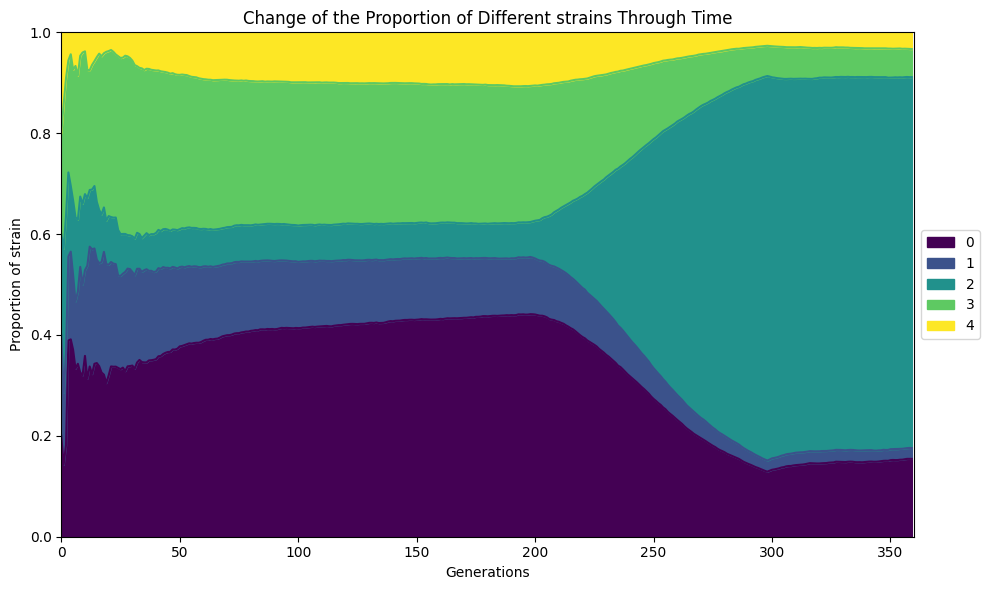

In [89]:
eff_size = pd.read_csv("/Users/px54/Documents/TB_software/covid_test/strain_trajectory.txt", header=None, names=range(5))
eff_size = pd.concat([pd.DataFrame({i: [1] for i in range(5)}), eff_size]).reset_index(drop=True)

eff_size_normalized = eff_size.div(eff_size.sum(axis=1), axis=0)

eff_size_normalized

ax = eff_size_normalized.plot(kind='area', stacked=True, figsize=(10, 6), cmap='viridis')

plt.xlabel('Generations')
plt.ylabel('Proportion of strain')
plt.title('Change of the Proportion of Different strains Through Time')
plt.ylim(0, 1)
plt.xlim(0, 360)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

SEIR Trajectory

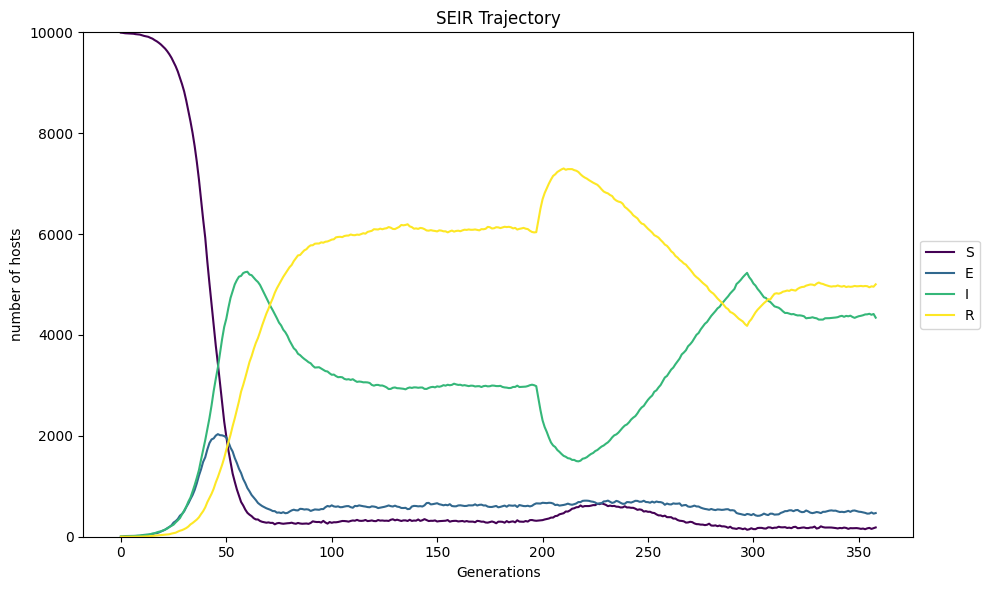

In [90]:
seir = pd.read_csv("/Users/px54/Documents/TB_software/covid_test/SIR_trajectory.txt", header=None, names=["S", "E", "I", "R"])
#eff_size = pd.concat([pd.DataFrame({i: [1] for i in range(10)}), eff_size]).reset_index(drop=True)
seir
ax = seir.plot(kind='line', figsize=(10, 6), cmap='viridis')

plt.xlabel('Generations')
plt.ylabel('number of hosts')
plt.title('SEIR Trajectory')
plt.ylim(0, 10000)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.show()

Divide the samples based on mutations and plot trajectory

Try with same transmissibility
Try linking with R